# ORIE 4580/5580/5581 Assignment 4

#### Students: Danielle Xu (dzx4) and Vicki Yang (vzy3)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Friday September 29, at 11.59am on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/56826#:~:text=Assignments-,Assignments,-Assignments%20Module%20publish). Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Bard or ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**. You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats




---
---


# Question 1: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


___
## Ans.

Assuming all three instruments are independent of each other, their probabilities of yielding positive returns are also independent. We can then determine that the probability of all three yielding a positive return is the product of their individual probabilities of yielding positive returns.

Therefore,
$P($all three yield positive return$) = P($U.S. stocks yields pos return$)*P($U.S. bonds yields pos return$)*P($EM bonds yields pos return).


To find the individual probabilities, we can treat the returns on each investment as normal random variables using the given mean and covariance values. For each investment, the probability of yielding a positive return, $P(X > 0) = 1 - P(X ≤ 0)$. Let $X_1$ represent the return on U.S. stocks, $X_2$ represent the return on U.S. bonds, and $X_3$ represent the return on EM bonds.

\\

$P(X_1 > 0) = 1 - P(X_1 \le 0) = 1 - P(Z_1 \le 0)$ where $Z_1 = \frac{(0-0.14)}{\sqrt{0.0625}} = -.56$

Using the z-score table, $P(X_1 > 0) = 1 - P(-.56 \le 0) = 1 - 0.2877 = 0.7123$

\\

$P(X_2 > 0) = 1 - P(X_2 \le 0) = 1 - P(Z_2 \le 0)$ where $Z_2 = \frac{(0-0.07)}
{\sqrt{0.01}} = -.7$

Using the z-score table, $P(X_2 > 0) = 1 - P(-.7 \le 0) = 1 - 0.2420 = 0.7580$

\\

$P(X_3 > 0) = 1 - P(X_3 \le 0) = 1 - P(Z_3 \le 0)$ where $Z_3 = \frac{(0-0.16)}
{\sqrt{0.09}} = -.5333$

Using scipy, $P(X_2 > 0) = 1 - P(-.7 \le 0) = 0.7030985713961488$


In [15]:
import numpy as np
from scipy.stats import norm

z3 = (0.16)/np.sqrt(0.09)

p_z3 = norm.cdf(z3)

print(p_z3)

0.7030985713961488


In [3]:
print(0.7123*0.7580*0.7030985713961488)

0.3796193712033515


Given that we've found all the individual probabilities for yielding positive returns, we can now determine the probability that all three investments simultatenously yield a positive return.

$P($all three yield a pos return$)$ = $0.7123*0.7580*0.7030985713961488$ $≈$ 0.37962

___

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
___

## Ans.



In [9]:
import numpy as np
from scipy import linalg

S = np.array([[0.0625, -0.01, -.0375], [-0.01, 0.01, -0.015], [0.0375, -0.015, 0.09]])
mu = np.array([0.14, 0.07, 0.16])

L = np.linalg.cholesky(S)

pos_yield = 0

for i in range(10000):
  N = np.random.normal(0, 1, 3)
  X = mu + L @ N
  if np.all(X > 0):
    pos_yield += 1

print("Estimated probability that all investments yield a pos return = " + str(pos_yield/10000))

Estimated probability that all investments yield a pos return = 0.3735


___
___

# Question 2: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

___

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.
___


## Ans.

Went to office hours for help:

$V_1 , V_2$ ~ Unif[$\alpha, \beta$]

mean: 0 = $\mathbb{E}[U]$ = ($\alpha + \beta$)/2

variance: 1 = Var(U) = $(\beta - \alpha)^2$/12

$\alpha = \sqrt3$, $\beta = -\sqrt3$

___

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?
___

## Ans.

\begin{align*}
    V_2 = (1-B)X_1 + BX_2 = \begin{cases} X_1 & \text{ w.p 1-p } \\ X_2 & \text{ w.p p } \end{cases}
    \end{align*}

$\mathbb{E}[V_2]$ = (1-p)(0) + (p)(0) = 0

$\mathbb{E}[V_2^2]$ = $\mathbb{E}[V_2^2|B=1] P(B=1)$ + $\mathbb{E}[V_2^2|B=0] P(B=0)$ = 1

$\mathbb{E}[V_2^2]$ = $\mathbb{E}[V_2^2|B=1](p)$ + $\mathbb{E}[V_2^2|B=0](1-p)$ = 1



$Var(V_2)$ = $\mathbb{E}[V_2^2] - (\mathbb{E}[V_2])^2$

$Var(V_2)$ = $\mathbb{E}[V_2^2|B=1](p)$ + $\mathbb{E}[V_2^2|B=0](1-p)$ - 0

___
**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?
___

## Ans.

$Cov(V_1, V_2 ) = \sigma_{12}$

$\sigma_{12}$ = $\mathbb{E}[V_1 V_2]$ - $\mathbb{E}[V_1]\mathbb{E}[V_2]$

$\sigma_{12}$ = $\mathbb{E}[V_1 V_2]$ - 0

$\sigma_{12}$ = $\mathbb{E}[X_1 X_1](1-p)$ + $\mathbb{E}[X_1 X_2](p)$

$\sigma_{12}$ = $\mathbb{E}[X_1^2](1-p)$ + $(0)(p)$ since $\mathbb{E}[X_1 X_2] = \mathbb{E}[X_1]\mathbb{E}[X_2]$

$\sigma_{12}$ = $1-p$ since $\mathbb{E}[X_1^2] = \mathbb{E}[V_1^2] = 1$

___

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

___

## Ans.

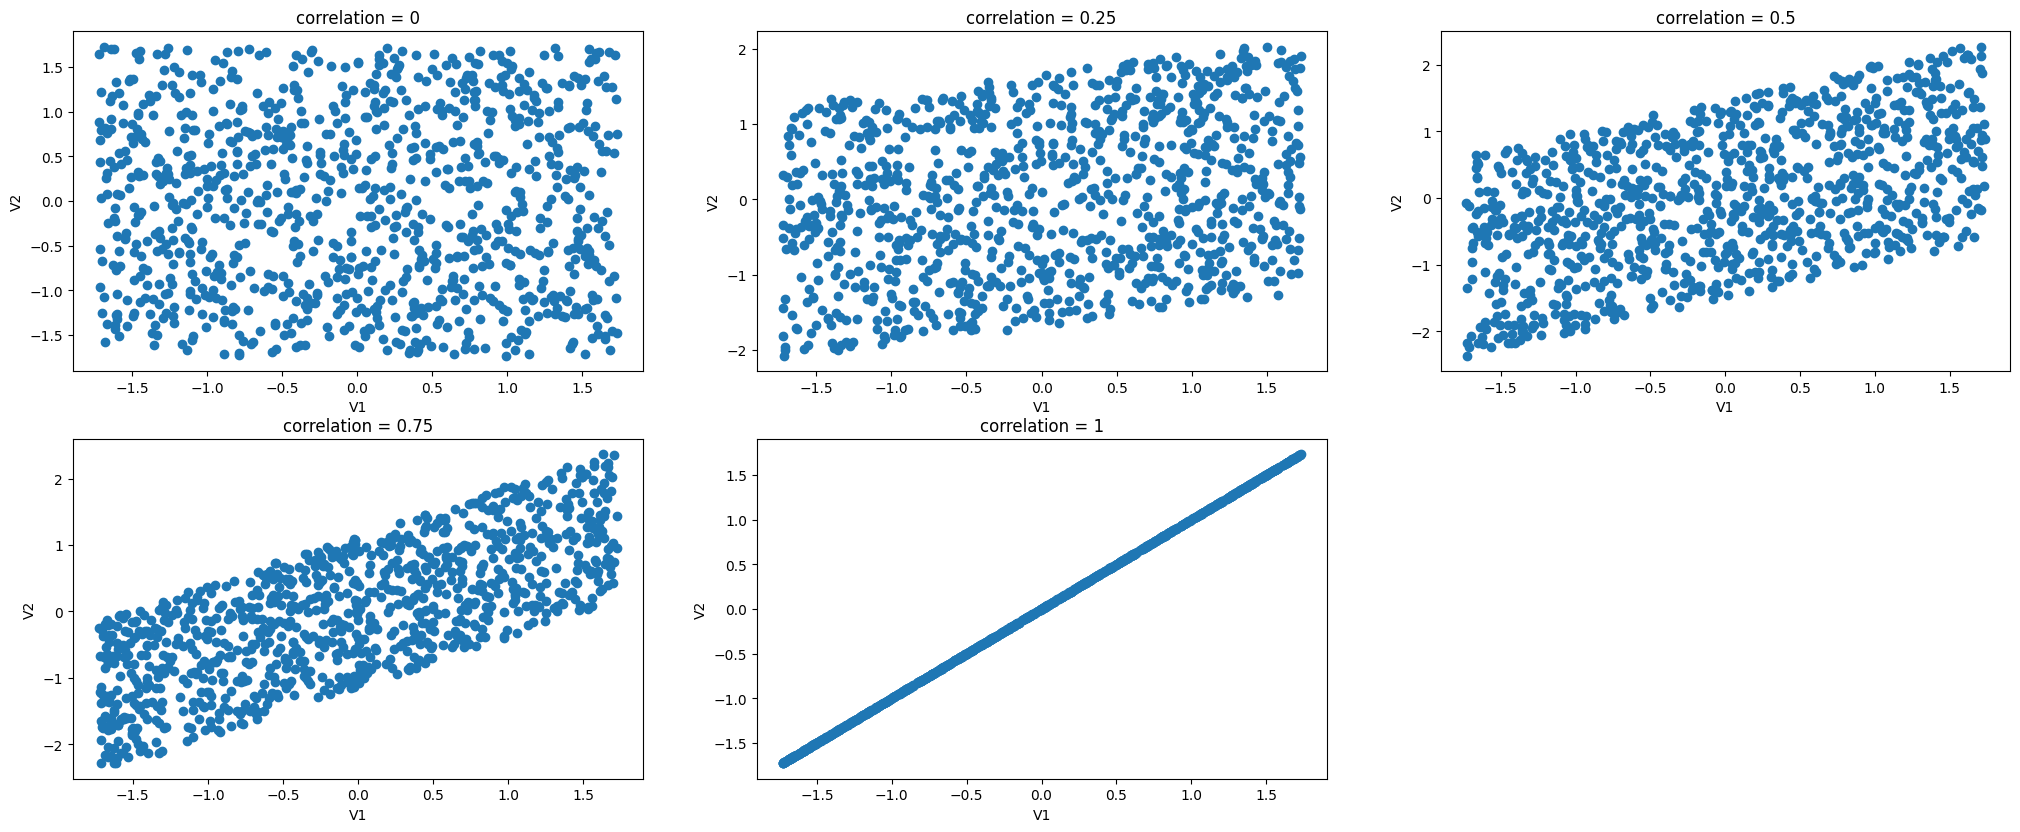

In [10]:
# Went to office hours for help
def corr_rvs(n, sigma_12):
    # uniform rvs
    sq3 = math.sqrt(3.0)
    u1 = np.random.rand(n)
    u2 = np.random.rand(n)

    u1 = u1*(sq3*2) - sq3 # uniform sampling at [0,1]
    u2 = u2*(sq3*2) - sq3

    scale = math.sqrt(1.0-sigma_12*sigma_12)

    v1 = u1
    v2 = sigma_12*u1 + scale*u2

    return v1, v2

n = 1000
p = [0, 0.25, 0.5, 0.75, 1]

plt.figure(figsize=(25, 15))

for i in range(len(p)):
    sigma_12 = p[i]
    v1, v2 = corr_rvs(n, sigma_12)

    plt.subplot(3, 3, i+1) #make diff subplots
    plt.scatter(v1, v2)
    plt.title(f"correlation = {sigma_12}")
    plt.xlabel("V1")
    plt.ylabel("V2")

plt.show()

___

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').
___

## Ans.

In [11]:
# Went to office hours for help
# ChatGPT was used to help debug this code.

num_sims = 100000

sigma_12 = 0.5

count_less_than_0 = 0

for _ in range(num_sims):
    v1, v2 = corr_rvs(1, sigma_12)

    if v1 <= 0:
        if v2 <= 0:
            count_less_than_0 += 1

# Estimate the probability
prob = count_less_than_0 / num_sims

print(prob)
# print(count_less_than_0)

0.32311


___

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

___

## Ans.
TO find distribution of $W-1$: what is cdf $W_1$? Leads to what is cdf $\phi(Z_1)$? Look at $\mathbb{P}(\phi(Z_1) \leq x)$

$W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$. Note: $\phi(Z_1)$ is a uniform random variable

CDF = $\mathbb{P}(\phi(Z_1) \leq x)$

CDF = $\mathbb{P}(Z_1 \leq \phi^{-1}(x))$ cdf of $Z_1$

CDF = $\phi(\phi^{-1}(x))$ bc equal to  x, can take derivative and set equal to 1 (cdf of $\phi(Z_1)$ is $x$)

CDF = $x$

----
$\phi(Z_1)$ ~ Unif[0,1]
$W_1$ ~ Unif[$\alpha, \beta$] if we scale it appropriately

The same logic applies to $W_2$, given $Z_2$. Thus, $W_1$ ~ Unif[$\alpha, \beta$] and $W_2$ ~ Unif[$\alpha, \beta$].

(P[W1≥0, W2≥0]= 0.3244


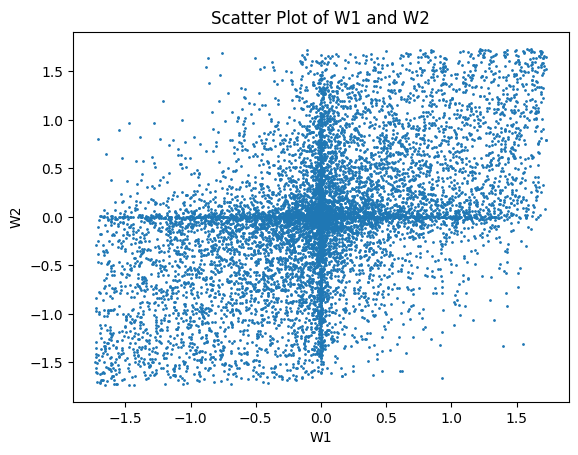

In [13]:
# Went to office hours for help
# ChatGPT was used to help debug this code

def gen_W(n, alpha, beta, sigma_12):
    # Z1 and Z2 are multivar rvs
    mean = [0, 0]
    cov_matrix = [[1, sigma_12], [sigma_12, 1]]
    Z1, Z2 = np.random.multivariate_normal(mean, cov_matrix, n).T

    # Calc U1, U2 using the standard normal CDF
    U1 = 0.5 * (1 + np.sign(Z1) * (1 - np.exp(-Z1**2 / 2)))
    U2 = 0.5 * (1 + np.sign(Z2) * (1 - np.exp(-Z2**2 / 2)))

    W1 = alpha + (beta - alpha) * U1
    W2 = alpha + (beta - alpha) * U2

    return W1, W2

num_sims = 10000

alpha = np.sqrt(3)
beta = -np.sqrt(3)
sigma_12 = 0.5

W1, W2 = gen_W(num_sims, alpha, beta, sigma_12)

plt.scatter(W1, W2, s=1)
plt.title("Scatter Plot of W1 and W2")
plt.xlabel("W1")
plt.ylabel("W2")

probability = np.mean((W1 >= 0) & (W2 >= 0))
print("(P[W1≥0, W2≥0]=", probability)

plt.show()

___
___

# Question 3: Generating random samples in some given set (20 pts)

___

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).
___

## Ans.

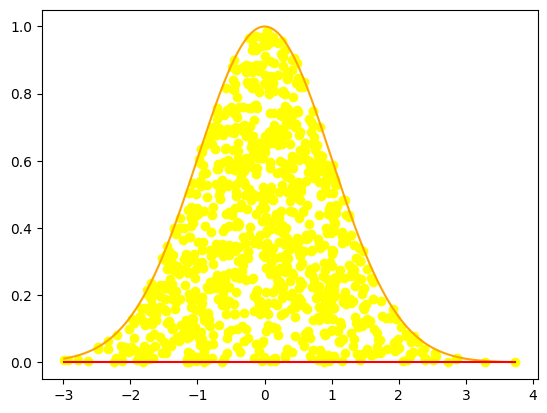

In [4]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import math

X = np.random.normal(0, 1, 1000)
Y = np.array([np.random.uniform(0, np.exp((-x**2)/2)) for x in X])

plt.scatter(X, Y, color='yellow')
x = np.arange(min(X),max(X),(max(X)-min(X))/1000)
plt.plot(x, np.exp(-x**2/2), color='orange')
plt.plot(x, x*0, color='red')

___
**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).
___

## Ans.

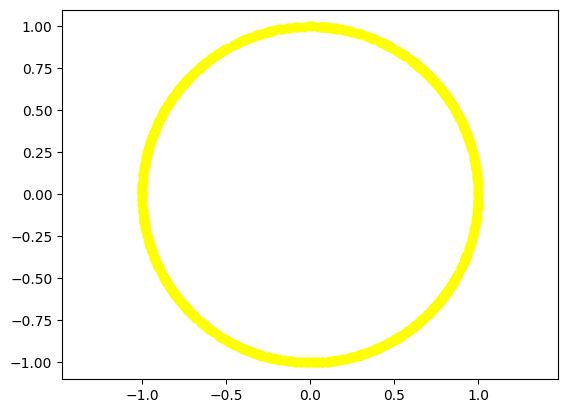

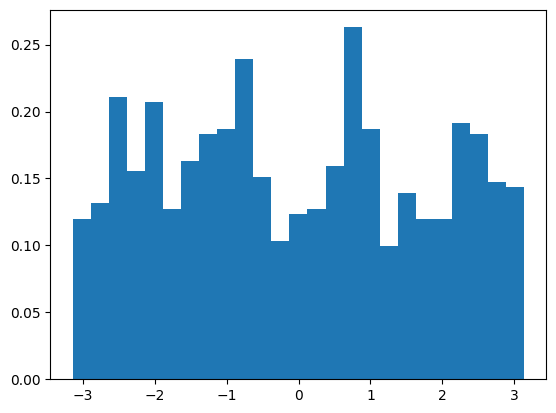

In [5]:
U = np.random.uniform(-1, 1, 1000)
V = np.random.uniform(-1, 1, 1000)

X = []
Y = []

for i in range(1000):
  X.append(U[i]/np.sqrt((U[i]**2)+(V[i]**2)))
  Y.append(V[i]/np.sqrt((U[i]**2)+(V[i]**2)))

plt.scatter(X, Y, color='yellow')
plt.axis('equal')
plt.show()

A = np.arctan2(Y,X)

plt.hist(A, bins=25, density=True)
plt.show()

The points are not uniformly distributed on the circumference of the circle. The histogram shows that the distribution is not uniform.



---

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$, and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

___

## Ans.

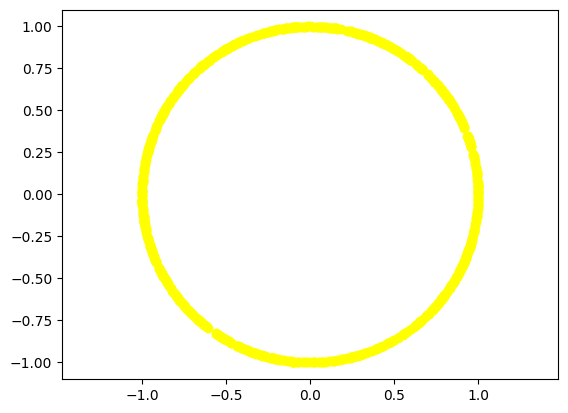

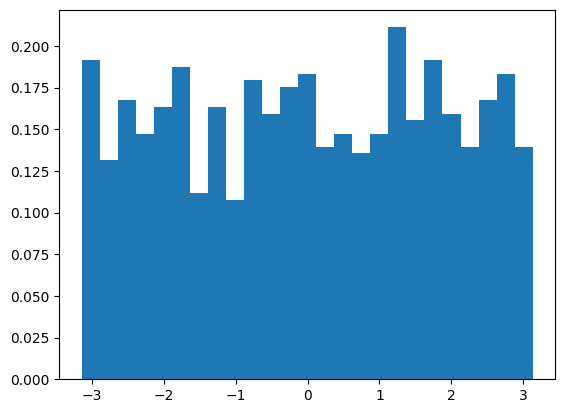

In [9]:
Z = np.random.randn(1000)
W = np.random.randn(1000)

X = []
Y = []

for i in range(1000):
  X.append(Z[i]/(np.sqrt((Z[i]**2)+(W[i]**2))))
  Y.append(W[i]/(np.sqrt((Z[i]**2)+(W[i]**2))))

plt.scatter(X, Y, color='yellow')
plt.axis('equal')
plt.show()

A = np.arctan2(Y, X)

plt.hist(A, bins=25, density=True)
plt.show()

Once again, the histogram shows that the points are not distributed uniformly on the circumference of the circle, but it is much more uniform than in part (b). This may be due to how we sampled our points. In part (b), we sampled from a normal distribution whereas in part (c), we sampled from a standard normal. This seems to indicate that sampling from a standard normal is a better approach for uniformity.  

___
___

# Question 4: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1,000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

___

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.
___


## Ans.

In [3]:
arrivals = np.random.uniform(0, 1000, 10000)
arrivals.sort

wait = np.zeros(10000)
for i in range(10000):
    # calculate waiting time
    wait[i] = 10 - (arrivals[i] % 10)

mean_wait_time = np.mean(wait)
var = np.var(wait, ddof=1)

z = stats.norm.ppf(0.95)

lb = mean_wait_time - z*np.sqrt(var/10000)
ub = mean_wait_time + z*np.sqrt(var/10000)

print(f"Mean Waiting Time: {mean_wait_time} minutes")
print(f"Confidence Interval: [{lb} minutes, {ub} minutes]")

Mean Waiting Time: 5.02944778367441 minutes
Confidence Interval: [4.982403419760432 minutes, 5.076492147588388 minutes]


___
**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.
___


## Ans.

In [4]:
times = []
inter_times = []
curr_time = 0
i = 0
while curr_time < 1000:
  inter_times.append(np.random.exponential(scale=10))
  curr_time += inter_times[i]
  times.append(curr_time)
  i += 1

wait2 = []

for a in arrivals:
  i = 0
  while times[i] < a:
    i += 1
  wait2.append(times[i] - a)

mean_wait2_time = np.mean(wait2)

print("Expected waiting time = " + str(mean_wait2_time) + " minutes")

Expected waiting time = 9.309451247651133 minutes


___

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

___

In [18]:
inter_a_times = np.diff(times)

mean3 = np.mean(inter_a_times)
var3 = np.var(inter_a_times, ddof=1)

z = stats.norm.ppf(0.95)

std_err = stats.sem(inter_a_times)
ci = stats.t.interval(0.95, df=len(inter_a_times)-1, loc=mean3, scale=std_err)

print(f"Confidence Interval for inter-arrival times: [{ci[0]} minutes, {ci[1]} minutes]")

Confidence Interval for inter-arrival times: [8.337623760824025 minutes, 12.055855027972962 minutes]


___

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

___

## Ans.

In [22]:
# we know this since it is a given that inter-arrival times in scenario are always 10 minutes since trains arrive deterministically every 10 minutes
print("Mean inter-arrival time for scenario (a) = 10 minutes")
print("95% CI for inter-arrival time in scenario (a) = [10 minutes, 10 minutes]")

# finding inter-arrival times for scenario (b)
print("Mean inter-arrival time for scenario (b) = " + str(np.mean(inter_times)))

z = stats.norm.ppf(0.95)

mean_inter = np.mean(inter_times)
var_inter = np.var(inter_times)

lb = mean_inter - z*np.sqrt(var_inter/10000)
ub = mean_inter + z*np.sqrt(var_inter/10000)

print(f"95% CI for inter-arrival time in scenario (b) = [{lb} minutes, {ub} minutes]")

Mean inter-arrival time for scenario (a) = 10 minutes
95% CI for inter-arrival time in scenario (a) = [10 minutes, 10 minutes]
Mean inter-arrival time for scenario (b) = 10.101550543574858
95% CI for inter-arrival time in scenario (b) = [9.94977853377311 minutes, 10.253322553376606 minutes]


The mean inter-arrival time for a passenger $i$ in scenario (a) will always be 10 minutes since trains always arrive in 10 minute intervals (this is given). The mean inter-arrival time for a passenger $i$ in scenario (b) is also approximately 10 minutes. These times are representative of the average actual time between train arrivals versus the waiting time is the amount of time a specific passenger may wait for their train (i.e. next train that arrives).

**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  